In [1]:
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

##  Downloading the Dataset

In [3]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz \

--2019-04-19 04:22:06--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.161.48, 2404:6800:4004:80a::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.161.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  90.7MB/s    in 2.4s    

2019-04-19 04:22:09 (90.7 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [4]:
!ls

flower_photos.tgz  sample_data


In [5]:
%%capture
!tar -xvf flower_photos.tgz 


flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [6]:
cd flower_photos

/content/flower_photos


In [0]:
mkdir train_data

content/flower_photos/train_data

In [0]:
mv daisy dandelion roses sunflowers tulips train_data

In [12]:
cd ..

/content


##  Importing and Preprocessing of Data

In [0]:
train_path = 'flower_photos/train_data/'

In [0]:
import os

In [0]:
base_path = 'flower_photos/train_data/'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
mapping = {}
count = 0
for i in categories:
    mapping[count] = i
    count+=1

### Load File Names

In [0]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [17]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [633, 898, 641, 699, 799]


In [0]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

### Load Images

In [0]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [20]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [633, 898, 641, 699, 799]


### Finding Minimum shape for each category

In [21]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

180,158 is the min shape for daisy
211,146 is the min shape for dandelion
200,159 is the min shape for roses
180,152 is the min shape for sunflowers
159,143 is the min shape for tulips


### Resizing Images

In [0]:
img_width, img_height = 48, 48

resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

### Splitting into training and testing set

In [0]:
from sklearn.model_selection import train_test_split
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.9, test_size=0.1)
    train_images.append(train)
    val_images.append(test)

### Create Labels

In [0]:
train_labels = np.zeros(sum([len(i) for i in train_images]))
count = 0
next_class = 0
for i in train_images:
    train_labels[next_class:next_class+len(i)] = count
    next_class += len(i)
    count+=1
    
val_labels = np.zeros(sum([len(i) for i in val_images]))
count = 0
next_class = 0
for i in val_images:
    val_labels[next_class:next_class+len(i)] = count
    next_class += len(i)
    count+=1

In [25]:
train_labels[1222:1226], val_labels[305:309]

(array([1., 1., 1., 1.]), array([4., 4., 4., 4.]))

### Converting Image data to numpy array

In [26]:
print(len(train_images))
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)
print(len(train_images))

5
3301


In [0]:
train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = keras.utils.to_categorical(train_labels, 5)
val_labels = keras.utils.to_categorical(val_labels, 5)

## Training and Building of model

### Creating Image Data generator

In [0]:
train_batches = ImageDataGenerator().flow(train_data,train_labels,batch_size = 32)
val_batches = ImageDataGenerator().flow(val_data,val_labels,batch_size = 32)


### Function to print sample images

In [0]:
def plot(img,figsize = (14,8),rows = 1, interp = False, titles =None):
    if type(img[0]) is np.ndarray:
        img = np.array(img).astype(np.uint8)
        if img.shape[-1] != 3:
            img = img.transpose((0,2,3,1))
    f = plt.figure(figsize=(26,18))
    cols = len(img)//rows if len(img) % 2==0 else len(img)//rows +1
    for i in range(len(img)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i],fontsize = 16)
        plt.imshow(cvtRGB(img[i]),interpolation=None if interp else 'None')

In [0]:
images,labels  = next(train_batches)

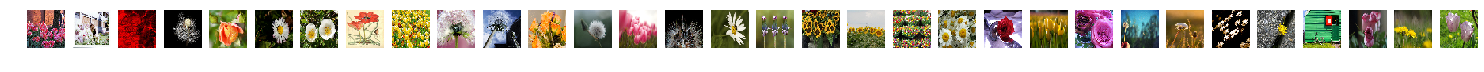

In [123]:
plot(images,labels)

### Building model

In [0]:
model = Sequential()

In [34]:
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (48, 48,3), name = 'Conv2d_1'))
model.add(Conv2D(32,(3,3),activation = 'relu', name = 'Conv2d_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2D_1'))
model.add(Dropout(0.25, name = 'Dropout_1'))

model.add(Conv2D(64,(3,3),activation = 'relu', name = 'Conv2d_3'))
model.add(Conv2D(64,(3,3),activation = 'relu', name = 'Conv2d_4'))
model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2D_2'))
model.add(Dropout(0.25, name = 'Dropout_2'))

model.add(Conv2D(128,(3,3),activation = 'relu', name = 'Conv2d_5'))
model.add(Conv2D(128,(3,3),activation = 'relu', name = 'Conv2d_6'))
model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2D_3'))
model.add(Flatten(name = 'Flatten'))
model.add(Dense(1024,activation='relu', name = 'Dense_1'))
model.add(Dropout(0.5, name = 'Dropout_3'))
model.add(Dense(512,activation='relu',name = 'Dense_2'))
model.add(Dense(64,activation='relu',name = 'Dense_3'))
model.add(Dense(5,activation='softmax', name = 'Dense_4'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 22, 22, 32)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
Conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
MaxPool2D_2 (MaxPooling2D)   (None, 9, 9, 64)          0         
__________

### Training model

In [37]:
model.fit_generator(train_batches,steps_per_epoch=len(train_data)//32,validation_steps=len(val_data)//4,validation_data=val_batches,epochs=50,verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
103/103 [==============================] - 7s 70ms/step - loss: 1.9207 - acc: 0.2489 - val_loss: 1.4845 - val_acc: 0.3695
Epoch 2/50
103/103 [==============================] - 1s 13ms/step - loss: 1.3800 - acc: 0.3899 - val_loss: 1.3203 - val_acc: 0.3814
Epoch 3/50
103/103 [==============================] - 1s 13ms/step - loss: 1.3023 - acc: 0.4371 - val_loss: 1.2602 - val_acc: 0.4674
Epoch 4/50
103/103 [==============================] - 1s 13ms/step - loss: 1.2103 - acc: 0.4927 - val_loss: 1.1424 - val_acc: 0.5632
Epoch 5/50
103/103 [==============================] - 1s 13ms/step - loss: 1.1673 - acc: 0.5343 - val_loss: 1.1777 - val_acc: 0.5230
Epoch 6/50
103/103 [==============================] - 1s 13ms/step - loss: 1.1226 - acc: 0.5467 - val_loss: 1.0752 - val_acc: 0.5655
Epoch 7/50
103/103 [==============================] - 1s 14ms/step - loss: 1.0250 - acc: 0.6023 - val_loss: 1.1415 - val_acc: 0.5576
Epoch 8/50
103/103 [=

### Saving the model

In [0]:
model.save('Flower_Image_classifier2.h5')

### Predicting against Sample Validation Data

In [0]:
test_imgs,test_labels = next(val_batches)

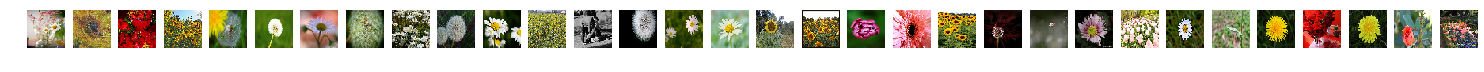

In [124]:
plot(test_imgs,test_labels)

In [0]:
test_labels = test_labels.argmax(axis = 1)

In [0]:
predictions = model.predict(test_imgs)

In [43]:
len(test_labels),len(predictions)

(32, 32)

In [0]:
predictions = predictions.argmax(axis=1)

In [45]:
predictions

array([0, 2, 2, 3, 1, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 0, 3, 3, 2, 2, 3, 1,
       1, 0, 0, 0, 1, 1, 2, 1, 2, 4])

In [46]:
test_labels

array([0, 3, 4, 3, 1, 1, 0, 1, 0, 1, 0, 3, 4, 1, 0, 0, 3, 3, 4, 2, 3, 1,
       0, 0, 4, 0, 1, 1, 2, 1, 2, 4])

In [47]:
print(accuracy_score(test_labels,predictions))

0.8125


## Testing on Outside Data

In [0]:
from skimage import io
img = cv2.imread('rose.webp')

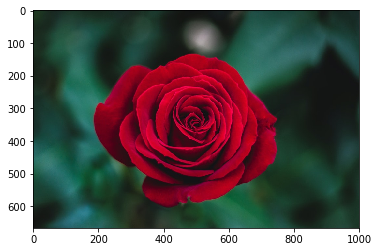

In [112]:
plt.imshow(cvtRGB(img))

In [0]:
img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
img = img.reshape(1,48,48,3).astype('float32')

In [114]:
model.predict(img).round(3)

array([[0.001, 0.   , 0.986, 0.   , 0.013]], dtype=float32)

In [115]:
print(f"The Photo is in the category of {mapping[model.predict_classes(img)[0]]}")

The Photo is in the category of roses


Another Category test

In [0]:
from skimage import io
img = cv2.imread('dandelion.jpg')

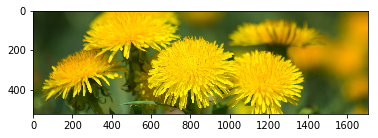

In [117]:
plt.imshow(cvtRGB(img))

In [0]:
img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
img = img.reshape(1,48,48,3).astype('float32')

In [119]:
model.predict(img).round(3)

array([[0.   , 0.93 , 0.   , 0.069, 0.002]], dtype=float32)

In [120]:
print(f"The Photo is in the category of {mapping[model.predict_classes(img)[0]]}")

The Photo is in the category of dandelion


In [0]:
def plot_model_history(model_name, history, epochs):
    print(model_name)
    plt.figure(figsize=(15, 5))

    # summarize history for accuracy
    plt.subplot(1, 2 ,1)
    plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
    plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
    plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='best')


    plt.show()

### Predict and Evaluate Model

model


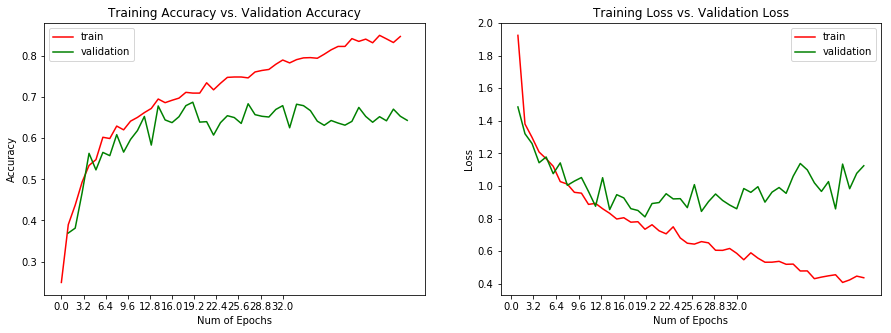

In [56]:
plot_model_history('model',model.history.history,32)